In [1]:
from alpdesign.utils import *
from alpdesign.mlp import *
from jax_unirep import get_reps
import alpdesign
import numpy as np
import matplotlib.pyplot as plt
import jax_unirep
import haiku as hk
import jax
import jax.numpy as jnp
import functools
from sklearn.decomposition import PCA

In [2]:
AA_list = ['A','R','N','D','C','Q','E','G','H','I','L','K','M','F','P','S','T','W','Y','V','B','Z','X','*']
blosum92 = np.loadtxt("./blosum62.txt", dtype='i', delimiter=' ')
avg92 = jnp.sum(blosum92)/24/24
sum92 = 0.
for row in blosum92:
    for aa in row:
        sum92 += (aa-avg92)**2
std92 = jnp.sqrt(sum92 / 24/24)

def blosum(seq1, seq2):
    seqlist1 = list(seq1)
    seqlist2 = list(seq2)
    score = 0.
    for i in range(len(seqlist1)):
        idx1 = AA_list.index(seqlist1[i])
        idx2 = AA_list.index(seqlist2[i])
        score += (blosum92[idx1][idx2] - avg92)/std92
        #jax.nn.sigmoid(score/len(seqlist1))
    return score/len(seqlist1)


In [22]:
target_seq = 'TARGETPEPTIDE'
oh_vec = encode_seq(list(target_seq))
oh_unirep = seq2useq(oh_vec)
target_rep = differentiable_jax_unirep(oh_unirep)
seqs = ['ISQLRYICEVIWF']
reps = get_reps(seqs)[0]
labels = []
for seq in seqs:
    labels.append(blosum(target_seq, seq))
labels = np.array(labels)
print(labels)


'''
target_seq = 'GIGAVLKVLT'
oh_vec = encode_seq(list(target_seq))
oh_unirep = seq2useq(oh_vec)
target_rep = differentiable_jax_unirep(oh_unirep)

seqs = ['GIGAVLKVLKAGLPALIVTLKRKIVQ',
       'PPGATLKKHTTGSVALISWIWARIQQ',
       'GIGAVLKVLTTGLKTLISAAKRKRAA',
       'HAPPVLKVLTTGLAPPLVWIKRKRTH',
       'GIGAVLUIHKLSSVAAWRPPKRKRQQ',
       'PTWIIFLKAQWEQHSNLTNMRTFPEV',
        'TISHFVCNHDICAWIKDMQAMQIKMC',
        'CESWLWKRLFDGHADRWRSMPDYPIW',
        'YLVENPLMFPLVAAFIHQWTRQISWH',
        'QTEERLEAQISIYYIGAWSHYKVTDE']


seqs = ['SSVAAWRPPK',
       'PPGATLKKHT',
       'LTGAVLKVLK',
       'HAPPVLKVLT',
       'AWRPPKRKRQ',
       'PTWIIFLKAQ',
       'TISHFVCNHD',
       'CESWLWKRLF',
       'YLVENPLMFP',
       'QTEERLEAQI',
       'GAWSHYKVTD',
       'HADRWRSMPD']
reps = get_reps(seqs)[0]
labels = []
for seq in seqs:
    labels.append(blosum(target_seq, seq))
labels = np.array(labels)
print(labels)


'''


[0.01368617]


"\ntarget_seq = 'GIGAVLKVLT'\noh_vec = encode_seq(list(target_seq))\noh_unirep = seq2useq(oh_vec)\ntarget_rep = differentiable_jax_unirep(oh_unirep)\n\nseqs = ['GIGAVLKVLKAGLPALIVTLKRKIVQ',\n       'PPGATLKKHTTGSVALISWIWARIQQ',\n       'GIGAVLKVLTTGLKTLISAAKRKRAA',\n       'HAPPVLKVLTTGLAPPLVWIKRKRTH',\n       'GIGAVLUIHKLSSVAAWRPPKRKRQQ',\n       'PTWIIFLKAQWEQHSNLTNMRTFPEV',\n        'TISHFVCNHDICAWIKDMQAMQIKMC',\n        'CESWLWKRLFDGHADRWRSMPDYPIW',\n        'YLVENPLMFPLVAAFIHQWTRQISWH',\n        'QTEERLEAQISIYYIGAWSHYKVTDE']\n\n\nseqs = ['SSVAAWRPPK',\n       'PPGATLKKHT',\n       'LTGAVLKVLK',\n       'HAPPVLKVLT',\n       'AWRPPKRKRQ',\n       'PTWIIFLKAQ',\n       'TISHFVCNHD',\n       'CESWLWKRLF',\n       'YLVENPLMFP',\n       'QTEERLEAQI',\n       'GAWSHYKVTD',\n       'HADRWRSMPD']\nreps = get_reps(seqs)[0]\nlabels = []\nfor seq in seqs:\n    labels.append(blosum(target_seq, seq))\nlabels = np.array(labels)\nprint(labels)\n\n\n"

In [23]:
key = jax.random.PRNGKey(0)
class NaiveBlock(hk.Module):
    def __init__(self, name=None):
        super().__init__(name=name)
    
    def __call__(self, x):
        out = hk.nets.MLP((256, 128, 64, 1,))(x)
        return out
    
def naive_forward(x):
    f = NaiveBlock()
    return f(x)
naive_forward_t = hk.without_apply_rng(hk.transform(naive_forward))

In [24]:
def _naive_loss(forward, params, seq, label):
    yhat = forward(params, seq) #scalar
    return (label-yhat)**2

def _shuffle_in_unison(key, a, b):
    # NOTE to future self: do not try to rely on keys being same
    # something about shape of arrays makes shuffle not the same
    assert len(a) == len(b)
    p = jax.random.permutation(key, len(a))
    return jnp.array([a[i] for i in p]), jnp.array([b[i] for i in p])


def _fill_to_batch(x, y, key, batch_size):
    if len(y) >= batch_size:
        return x, y
    i = jax.random.choice(key, jnp.arange(len(y)),
                          shape=(batch_size,), replace=True)
    x = x[i, ...]
    y = y[i, ...]
    return x, y


def naive_train(key, forward_t, seqs, labels, val_seqs=None, val_labels=None, params=None, epochs=3, batch_size=8, learning_rate=1e-2):
    opt_init, opt_update = optax.chain(
        optax.scale_by_adam(b1=0.8, b2=0.9, eps=1e-4),
        optax.scale(-learning_rate)  # minus sign -- minimizing the loss
    )

    key, bkey = jax.random.split(key)

    # fill in seqs/labels if too small
    seqs, labels = _fill_to_batch(seqs, labels, bkey, batch_size)
   
        
    if params == None:
        params = forward_t.init(key, seqs[0])
  
    opt_state = opt_init(params)

    # wrap loss in batch/sum
    loss_ = partial(_naive_loss, forward_t.apply)
    loss_fxn = lambda *args: jnp.mean(jax.vmap(loss_, in_axes=(None, 0, 0))(*args))
    #loss_fxn = jnp.mean(jax.vmap(loss_, in_axes=(None, 0, 0)))

    @jax.jit
    def train_step(opt_state, params, seqs, labels):
        loss, grad = jax.value_and_grad(loss_fxn, 0)(
            params, seqs, labels)
        updates, opt_state = opt_update(grad, opt_state, params)
        params = optax.apply_updates(params, updates)
        return opt_state, params, loss
    losses = []
    val_losses = []
    for e in range(epochs):
        # shuffle seqs and labels
        key, key_ = jax.random.split(key, num=2)
        shuffle_seqs, shuffle_labels = _shuffle_in_unison(key, seqs, labels)
        for i in range(0, len(shuffle_labels) // batch_size):
            seq = shuffle_seqs[i:(i+1) * batch_size]
            label = shuffle_labels[i:(i+1) * batch_size]
            opt_state, params, loss = train_step(opt_state, params, seq, label)
            losses.append(loss)
        # compute validation loss
        if val_seqs is not None:
            val_loss = 0.
            for i in range(0, len(val_labels) // batch_size):
                seq = shuffle_seqs[i:(i+1) * batch_size]
                label = shuffle_seqs[i:(i+1) * batch_size]
                val_loss += loss_fxn(
                    params,
                    val_seqs[i:(i+1) * batch_size],
                    val_labels[i:(i+1) * batch_size])
            val_loss = val_loss/len(val_labels) * batch_size
            #batch_loss += loss
            val_losses.append(val_loss)
    return (params, losses) if val_seqs is None else (params, losses, val_losses)

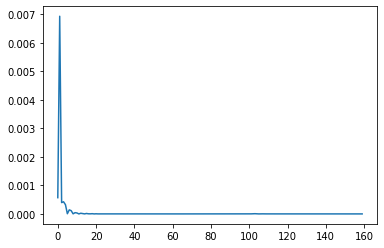

In [25]:
params, losses = naive_train(
    key, naive_forward_t, reps, labels, epochs=160, learning_rate=1e-3)
#forward_t = hk.without_apply_rng(hk.transform(forward_fxn))
#forward = functools.partial(forward_t.apply, params)
plt.plot(losses)

In [26]:
def e2e(params, logits): # params is trained mlp params
    s = alpdesign.SeqpropBlock()(logits)
    us = alpdesign.seq2useq(s)
    u = alpdesign.differentiable_jax_unirep(us)
    forward = functools.partial(naive_forward_t.apply, params)
    return forward(u)
#e2e_t = hk.transform(e2e)
#init_logits = jax.random.normal(key, shape=((10, 20)))
#e2e_params = e2e_t.init(key, init_logits)

def e2e_fxn(e2e_t, x, key):
    e2e_params, logits = x
    yhat = e2e_t.apply(e2e_params, key, logits)
    return yhat

In [27]:
def gradient_opt(key, f, init_x=None, iter_num=500, learning_rate=1e-2):
    optimizer = optax.adam(-learning_rate)
    opt_state = optimizer.init(init_x)
    x = init_x
    reduced_f = lambda *args: jnp.mean(f(*args))
    
    @jax.jit
    def step(x, opt_state, key):
        loss, g = jax.value_and_grad(reduced_f, 0)(x, key)
        updates, opt_state = optimizer.update(g, opt_state)
        x = optax.apply_updates(x, updates)
        return x, opt_state, loss
    losses = []
    for step_idx in range(iter_num):
        key, _ = jax.random.split(key, num=2)
        x, opt_state, loss= step(x, opt_state, key)
        losses.append(loss)
            
    return x, losses

In [30]:
batch_size = 5
BO_batch_size = 16
reps = get_reps(seqs)[0]
labels = []
for seq in seqs:
    labels.append(blosum(target_seq, seq))
labels = np.array(labels)
def loop(key, reps, labels, params, rb=None):
    key, train_key = jax.random.split(key, num=2)
    params, mlp_loss= naive_train(key, naive_forward_t, reps, labels, params=params, epochs=160)
    # make random point
    init_logits = 0.1*jax.random.normal(key, shape=((13, 20)))
    e2e_ = lambda logits: functools.partial(e2e, params)(logits)
    e2e_t = hk.transform(e2e_)
    key, train_key = jax.random.split(key, num=2)
    if rb is None:
        rb = e2e_t.init(key, init_logits)
    e2e_params = rb
    key, train_key = jax.random.split(key, num=2)
    #init_x = 0.1*jax.random.normal(key, shape=(BO_batch_size, 10, 20))
    #forward = jax.vmap(lambda x, key: forward_t.apply(params, x), in_axes=(0, None))
    print('start optimizing')
    #batch_e2e = jax.vmap(lambda x, key: functools.partial(e2e_fxn, e2e_t)(params, x), in_axes=((None, 0), None))
    batch_e2e = functools.partial(e2e_fxn, e2e_t)
    #batched_x, bo_losses = alpdesign.mlp.bayes_opt(key, batch_e2e, labels, (e2e_t.init(train_key, init_logits), init_x), epsilon=0.01, iter_num=500)
    x, losses = gradient_opt(key, batch_e2e, (e2e_params, init_logits))
    #top_idx = np.argmin(bo_losses[-1])
    rb = x[0]
    logits = x[1]
    
    vec = alpdesign.seq.forward_seqprop.apply(rb, key, logits)
    s = decode_seq(vec)
    reps = np.concatenate((reps, get_reps([s])[0]))
    #print(get_reps([s])[0])
    y = blosum(target_seq, s)
    predicted_y = naive_forward_t.apply(params, get_reps([s])[0])
    print(reps.shape)
    print(s, y, predicted_y)
    labels = np.concatenate((labels, np.array(y).reshape(1,)))
    return key, reps, labels, s, params

In [ ]:
key = jax.random.PRNGKey(0)
y = []
yhat = []
for i in range(100):
    print(i)
    rb = None
    params = None
    key, reps, labels, final_vec, params= loop(key, reps, labels, params)
    print(final_vec)
    y.append(blosum(target_seq, final_vec))
    yhat.append(naive_forward_t.apply(params, get_reps([final_vec])[0])[0])

0
start optimizing
(102, 1900)
['K', 'R', 'E', 'M', 'K', 'Q', 'R', 'R', 'N', 'E', 'Q', 'Q', 'E'] 0.29776552 [[0.48825538]]
['K', 'R', 'E', 'M', 'K', 'Q', 'R', 'R', 'N', 'E', 'Q', 'Q', 'E']
1
start optimizing
(103, 1900)
['R', 'E', 'E', 'K', 'E', 'R', 'K', 'E', 'E', 'T', 'E', 'S', 'Q'] 0.83041435 [[0.5417428]]
['R', 'E', 'E', 'K', 'E', 'R', 'K', 'E', 'E', 'T', 'E', 'S', 'Q']
2
start optimizing
(104, 1900)
['M', 'D', 'R', 'E', 'A', 'E', 'T', 'K', 'R', 'D', 'P', 'N', 'A'] 0.29776552 [[0.38781047]]
['M', 'D', 'R', 'E', 'A', 'E', 'T', 'K', 'R', 'D', 'P', 'N', 'A']
3
start optimizing
(105, 1900)
['K', 'K', 'R', 'A', 'R', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E'] 0.8659243 [[0.6793434]]
['K', 'K', 'R', 'A', 'R', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E']
4
start optimizing
(106, 1900)
['P', 'K', 'A', 'E', 'E', 'A', 'E', 'A', 'Q', 'Q', 'Q', 'E', 'E'] 0.58184487 [[0.5328597]]
['P', 'K', 'A', 'E', 'E', 'A', 'E', 'A', 'Q', 'Q', 'Q', 'E', 'E']
5
start optimizing
(107, 1900)
['T', 'K', 'E', 'A', 'N', 'E

In [ ]:
plt.figure()
plt.plot(y,label='y')
plt.plot(yhat, label='yhat')
plt.legend()
plt.title('baseline(max)')